<a href="https://colab.research.google.com/github/subhamadhikari/malaria-detection/blob/main/MalariaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Layer,Conv2D,MaxPool2D,Dense,InputLayer,Flatten,BatchNormalization,Input,Dropout,RandomContrast,RandomFlip,RandomRotation,Resizing,Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import L2,L1
from tensorboard.plugins.hparams import api as hp

# Downloading DataSETS

In [ ]:
dataset,dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [ ]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

d_set = tf.data.Dataset.range(10)
print(list(d_set.as_numpy_iterator()))

D_SIZE = len(d_set)

train_d_set = d_set.take(int(TRAIN_RATIO*D_SIZE))
print(list(train_d_set.as_numpy_iterator()))

val_test_d_set = d_set.skip(int(TRAIN_RATIO*D_SIZE))
val_d_set = val_test_d_set.take(int(VAL_RATIO*D_SIZE))
print(list(val_d_set.as_numpy_iterator()))

test_d_set = val_test_d_set.skip(int(VAL_RATIO*D_SIZE))
print(list(test_d_set.as_numpy_iterator()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5]
[6, 7]
[8, 9]


In [ ]:
for data in dataset[0]:
  print(data)
  break

len(dataset[0])


(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)


27558

#Splitting datasets

In [ ]:
def splits(dataset,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))
  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset,val_dataset,test_dataset

In [ ]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

train_dataset,val_dataset,test_dataset = splits(dataset[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
# print(list(train_dataset)[1])
# print(list(train_dataset.take(1).as_numpy_iterator())[0][0].shape)
# print(len(val_dataset))
# print(len(test_dataset))
list(train_dataset.take(1))
train_dataset

NameError: ignored

#DATA `Visualization`

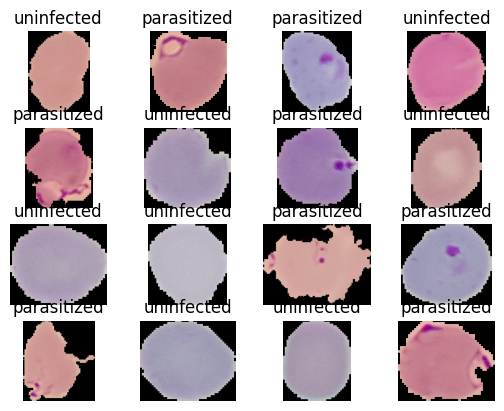

In [ ]:
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis(False)
  pass

#Data PreProcessing

## Data AuGMENTATION

In [ ]:
def visualize(original,augmented):
  plt.subplot(1,2,1)
  plt.imshow(original)
  plt.subplot(1,2,2)
  plt.imshow(augmented)

In [ ]:
original_image,label=next(iter(train_dataset))
# label=next(iter(train_dataset))[0][1]

In [ ]:
# augmented_image = tf.image.random_flip_up_down(original_image)

In [ ]:
augmented_image = tf.image.adjust_brightness(original_image,delta=0.1)

In [ ]:
# augmented_image = tf.image.random_saturation(original_image,lower=2,upper=12)

In [ ]:
# augmented_image = tf.image.central_crop(original_image,central_fraction=0.8)

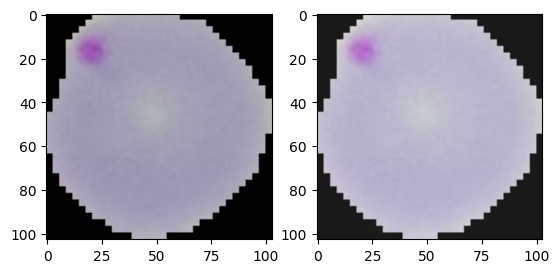

In [ ]:
visualize(original_image,augmented_image)

---

In [ ]:
IM_SIZE = 224
original_image,label = next(iter(train_dataset))
#  changing the function to graph mode usinh the decorator
# @tf.function
def resize_rescale(image,label):
  # print("I was here")
  # tf.print("I am here too!")
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255,label

_,a =  resize_rescale(original_image,label)
_,a =  resize_rescale(original_image,label)
_,a =  resize_rescale(original_image,label)


NameError: ignored

In [ ]:
tf.config.run_functions_eagerly(False)
_,a =  resize_rescale(original_image,label)
_,a =  resize_rescale(original_image,label)

I am here too!
I am here too!


### tf.image augmentatiion

In [ ]:
# @tf.function
def augment(image,label):
  image,label = resize_rescale(image,label)
  image = tf.image.rot90(image,k=tf.random.uniform(shape=[],minval=0,maxval=2,dtype=tf.int32))
  # image = tf.image.adjust_saturation(image,saturation_factor=0.3)
  image = tf.image.flip_left_right(image)
  return image,label


### custom data augmentation

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()
  @tf.function
  def call(self,image):
    return tf.image.rot90(image,k=tf.random.uniform(shape=[],minval=0,maxval=2,dtype=tf.int32))

### tf.keras.layer augmentatiion

In [ ]:
# augment_layers = tf.keras.Sequential([
#     RandomRotation(factor=(0.25,0.2501)),
#     RandomFlip(mode='horizontal'),
#     RandomContrast(factor=0.1)
# ])
augment_layers = tf.keras.Sequential([
    RotNinety(),
    RandomFlip(mode='horizontal')
])
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IM_SIZE,IM_SIZE),
    Rescaling(1.0/255)
])
@tf.function
def augment_layer(image,label):
  # image,label = resize_rescale(image,label)
  return augment_layers(resize_rescale(image),training=True),label

In [ ]:
print(list(train_dataset.take(1)))
#resizing every images to equal height and width
# train_dataset = train_dataset.map(augment) augmented has been done below after shuffling
# val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)
print(list(train_dataset.take(1)))

[(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)]
I was here
[(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]], shape=(103, 103, 3), dtype=uint8) tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
# train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(augment_layer).batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resize_rescale).batch(32).prefetch(tf.data.AUTOTUNE)
# train_dataset = (train_dataset
#                  .shuffle(buffer_size=8,reshuffle_each_iteration=True)
#                  .batch(1)
#                  .prefetch(tf.data.AUTOTUNE))
# if using data augmentation and resizing in the model itself, set the batch for train&val to 1 for not getting error
# val_dataset = (val_dataset
#                .shuffle(buffer_size=8,reshuffle_each_iteration=True)
#                .batch(1)
#                .prefetch(tf.data.AUTOTUNE))
val_dataset = (val_dataset
               .shuffle(buffer_size=8,reshuffle_each_iteration=True)
               .map(resize_rescale)
               .batch(32)
               .prefetch(tf.data.AUTOTUNE))


#CutMix Data Augmentation

In [ ]:
import cv2

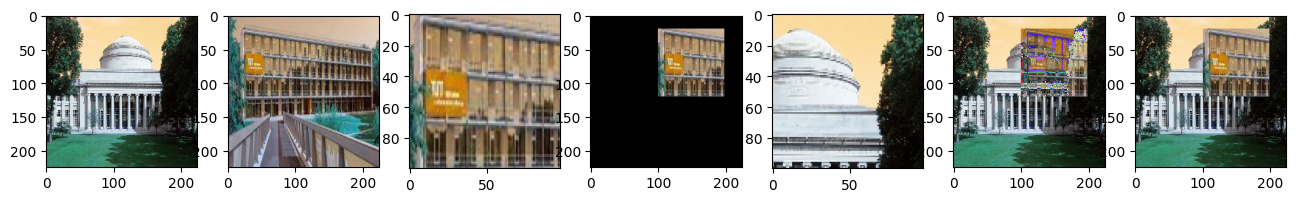

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,7,1)
image_1 = cv2.resize(cv2.imread('u1.jpg'),(IM_SIZE,IM_SIZE))
plt.imshow(image_1)

plt.subplot(1,7,2)
image_2 = cv2.resize(cv2.imread('u2.jfif'),(IM_SIZE,IM_SIZE))
plt.imshow(image_2)

plt.subplot(1,7,3)
crop_2 = tf.image.crop_to_bounding_box(image_2,20,15,100,98)
plt.imshow(crop_2)

plt.subplot(1,7,4)
image_4=tf.image.pad_to_bounding_box(crop_2,20,100,IM_SIZE,IM_SIZE)
plt.imshow(image_4)

plt.subplot(1,7,5)
crop_1 = tf.image.crop_to_bounding_box(image_1,20,100,100,98)
plt.imshow(crop_1)

plt.subplot(1,7,6)
plt.imshow(image_4+image_1)

plt.subplot(1,7,7)
image_5=tf.image.pad_to_bounding_box(crop_1,20,100,IM_SIZE,IM_SIZE)
plt.imshow(image_1 - image_5 + image_4)




#Mixup Data Augmentation

In [ ]:
image_1 = cv2.resize(cv2.imread('u1.jpg'),(IM_SIZE,IM_SIZE))
image_2 = cv2.resize(cv2.imread('u2.jfif'),(IM_SIZE,IM_SIZE))
print(image_1.shape)
print(image_2.shape)

(224, 224, 3)
(224, 224, 3)


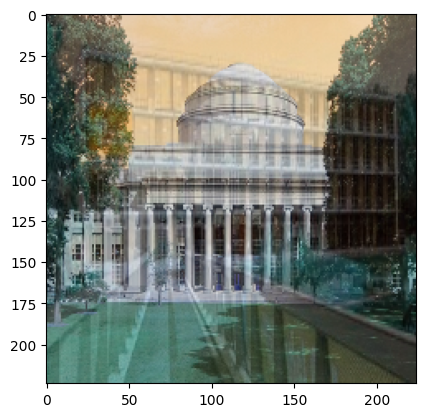

In [ ]:
lamda = tfp.distributions.Beta(
    0.2,0.2
)
lamda=lamda.sample(1)[0]

label_1=0
label_2=1

image = lamda*image_1 + (1-lamda)*image_2
labelN = lamda*label_1 + (1-lamda)*label_2
# print(image.shape)
plt.imshow(image/255)
# image

In [ ]:
train_dataset_1 = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resize_rescale)
train_dataset_2 = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resize_rescale)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1,train_dataset_2))

I was here


In [ ]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0,IM_SIZE).sample(1)[0],dtype=tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0,IM_SIZE).sample(1)[0],dtype=tf.int32)

  r_w = tf.cast(IM_SIZE * tf.math.sqrt(1-lamda),dtype=tf.int32)
  r_h = tf.cast(IM_SIZE * tf.math.sqrt(1-lamda),dtype=tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2,0,IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2,0,IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2,0,IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2,0,IM_SIZE)

  r_w = x_b_r - r_x
  r_h = y_b_r - r_y

  if(r_w == 0):
    r_w = 1

  if(r_h == 0):
    r_h = 1

  return r_y,r_x,r_h,r_w

In [ ]:
def mixup(train_dataset_1,train_dataset_2):
  # mixup
  # (image_1,label_1),(image_2,label_2) = train_dataset_1,train_dataset_2

  # lamda = tfp.distributions.Beta(0.2,0.2)
  # lamda=lamda.sample(1)[0]

  # image = lamda*image_1 + (1-lamda)*image_2
  # label = lamda*tf.cast(label_1,dtype=tf.float32) + (1-lamda)*tf.cast(label_2,dtype=tf.float32)

  #cut-mix
  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  (image_1,label_1),(image_2,label_2) = train_dataset_1,train_dataset_2

  r_y,r_x,r_h,r_w = box(lamda)

  crop_1 = tf.image.crop_to_bounding_box(image_1,r_y,r_x,r_h,r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1,r_y,r_x,IM_SIZE,IM_SIZE)

  crop_2 = tf.image.crop_to_bounding_box(image_2,r_y,r_x,r_h,r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2,r_y,r_x,IM_SIZE,IM_SIZE)

  image = image_1 - pad_1 + pad_2
  lamda = tf.cast(1 - ((r_h*r_w)/(IM_SIZE*IM_SIZE)),dtype=tf.float32)
  label = lamda*tf.cast(label_1,dtype=tf.float32) + (1-lamda)*tf.cast(label_2,dtype=tf.float32)

  return image,label

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    mixed_dataset
    .shuffle(buffer_size=8,reshuffle_each_iteration=True)
    .map(mixup)
    # .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
I am here too!
tf.Tensor([1.], shape=(1,), dtype=float32)


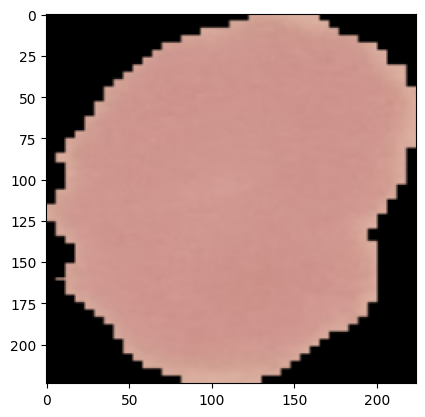

In [ ]:
original_image , label = next(iter(train_dataset))
plt.imshow(original_image[0])
print(label)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

#Albumentation

In [ ]:
import albumentations as A

In [ ]:
IM_SIZE=224
transforms = A.Compose([
    # A.Resize(IM_SIZE,IM_SIZE),
    A.OneOf([A.HorizontalFlip(),
    A.VerticalFlip()],p=0.3),
    A.RandomRotate90(),
    # A.RandomGridShuffle(),
    A.RandomBrightnessContrast(
        brightness_limit=0.2,contrast_limit=0.2,
        brightness_by_max=True,always_apply=False,p=0.5
    ),
    # A.Sharpen(alpha=(0.2,0.5),lightness=(0.5,1.0),always_apply=False,p=0.5)
])

In [ ]:
def aug_albument(image):
  data = {"image":image}
  image = transforms(**data)
  image = image["image"]
  image = tf.cast(image/255.,tf.float32)

In [ ]:
def process_data(image,label):
  aug_img = tf.numpy_function(func=aug_albument,inp=[image],Tout=tf.float32)
  return aug_img,label

it's not working

In [ ]:
BATCH_SIZE = 32
train_dataset = (
    train_dataset
    .shuffle(buffer_size=1024,reshuffle_each_iteration=True)
    .map(process_data)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>

In [ ]:
# im,_ = next(iter(train_dataset))
# plt.imshow(im)

In [ ]:
# plt.figure(figsize=(10,10))
# for i in range(1,32):
#   plt.subplot(8,4,i)
#   plt.imshow(im[i])

#Model Creation
`Sequntial`

## LeNet Cinvolutional Model

In [ ]:
from keras.src.engine.input_layer import InputLayer
# adding dropout layer
dropout_rate=0.2
model = tf.keras.Sequential([
    # InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    InputLayer(input_shape=(None,None,3)),
    #embedding data augmentation in the model
    resize_rescale_layers,
    augment_layers,
    # adding regularization component
    Conv2D(filters=6,kernel_size=3,strides=(1,1),padding='valid',
            activation='relu',kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Dropout(rate=dropout_rate),
    Conv2D(filters=16,kernel_size=3,strides=(1,1),padding='valid',
                           activation='relu',kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Dropout(rate=dropout_rate),
    Flatten(),
    Dense(100,activation="relu",kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Dense(10,activation="relu",kernel_regularizer=L2(0.01)),
    BatchNormalization(),
    Dense(1,activation="sigmoid"),
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)      

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics='accuracy')

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None))>

In [ ]:
# history = model.fit(train_dataset,
#                     epochs=20,
#                     verbose=1)

In [ ]:
# plt.plot(history.history['loss'])
# plit.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel("loss")
# plt.xlabel("epoch")
# plt.legend(['train_loss','val_loss'])
# plt.show()

In [ ]:
# plt.plot(history.history['accuracy'])
# plit.plot(history.history['val_loss'])
# plt.title('Model Accuracy')
# plt.ylabel("Accuracy")
# plt.xlabel("epoch")
# plt.legend(['train_acc','val_acc'])
# plt.show()

##Model Evaluation and Testing

In [ ]:
# test_dataset = test_dataset.unbatch()
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# model.evaluate(test_dataset)

In [ ]:
# model.predict(test_dataset.take(1))[0][0]

In [ ]:
def parasite_or_not(x):
  if(x < 0.5):
    return str('P')
  else:
    return str('U')

In [ ]:
# parasite_or_not(model.predict(test_dataset.take(1))[0][0])

In [ ]:
# for i,(image,label) in enumerate(test_dataset.take(9)):
  # print(image[0])
  # print(label)
  # ax = plt.subplot(3,3,i+1)
  # plt.imshow(image[0])
  # plt.title(str(parasite_or_not(label.numpy()[0]))+":"+str(parasite_or_not(model.predict(image))[0][0]))
  # plt.axis("off")


##**`Saving`** and Loading Model

### Saving `configurations` and `wights`

In [ ]:
# model.save('lenet')

In [ ]:
# lenet = tf.keras.models.load_model("lenet")
# lenet.summary()

### Saving only `weights`

In [ ]:
# lenet.save_weights("weights/lenet_weghts")

In [ ]:
# lenet_weights_model = lenet.load_weights('weights/lenet_weghts')

###Saving to and Loading from Google Drive

####`Saving`

In [ ]:
# from google.colab import drive

In [ ]:
# drive.mount('/content/drive')

In [ ]:
# !cp -r /content/lenet/ /content/drive/MyDrive/lenet_colab/

####`Loading`

In [ ]:
# !cp -r /content/drive/MyDrive/lenet_colab/ /content/lenet_colab/

#Functioal API

In [ ]:
from tensorflow.keras.models import Model

Feature Extrctor using Sequential

In [ ]:
feature_extractor_seq_model = tf.keras.Sequential([
    # InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    InputLayer(input_shape=(None,None,3)),
    # adding data augmentation inside the model
    resize_rescale_layers,
    augment_layers,
    Conv2D(filters=6,kernel_size=3,strides=(1,1),padding='valid',
                           activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Conv2D(filters=16,kernel_size=3,strides=(1,1),padding='valid',
                           activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2)
])
feature_extractor_seq_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)     

In [ ]:
# func_input = Input(shape=(IM_SIZE,IM_SIZE,3),name="Input_Image")
func_input = Input(shape=(None,None,3),name="Input_Image")

x = Conv2D(filters=6,kernel_size=3,strides=(1,1),padding='valid',
                           activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)
x = Conv2D(filters=16,kernel_size=3,strides=(1,1),padding='valid',
                           activation='relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D(pool_size=2,strides=2)(x)

feature_exractor_model = Model(func_input,output,name="Feature_Extractor_Model")
feature_exractor_model.summary()

Model: "Feature_Extractor_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 6)     168       
                                                                 
 batch_normalization_2 (Bat  (None, None, None, 6)     24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, None, None, 6)     0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 16)    880       
                                                                 
 batch_normalization_3 (Bat  (None, None, N

## Callable Models

In [ ]:
# func_input = Input(shape=(IM_SIZE,IM_SIZE,3),name="Input_Image")
func_input = Input(shape=(None,None,3),name="Input_Image")

# these are feature extraction layers

# x = Conv2D(filters=6,kernel_size=3,strides=(1,1),padding='valid',
#                            activation='relu')(func_input)
# x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=2,strides=2)(x)
# x = Conv2D(filters=16,kernel_size=3,strides=(1,1),padding='valid',
#                            activation='relu')(x)
# x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=2,strides=2)(x)

# x = feature_exractor_model(func_input)
#or
x = feature_extractor_seq_model(func_input)

x = Flatten()(x)

#these layers helps in classification
x = Dense(100,activation="relu")(x)
x = BatchNormalization()(x)
x = Dense(10,activation="relu")(x)
x = BatchNormalization()(x)
func_output = Dense(1,activation="sigmoid")(x)

lenet_model = Model(func_input,func_output,name="Lenet_Model")
lenet_model.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Image (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential_2 (Sequential)   (None, 54, 54, 16)        1136      
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_4 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                       

### CUSTOM LOSS CLASS

In [ ]:
FACTOR = 1
class CustomBCE(tf.keras.losses.Loss):
  def __init__(self,FACTOR):
    super(CustomBCE,self).__init__()
    self.FACTOR = FACTOR

  def call(self,y_true,y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true,y_pred)*self.FACTOR

### Custom Loss
METHOD

In [ ]:
FACTOR = 1
def custom_bce(FACTOR):
  def loss(y_true,y_pred):
    bce = BinaryCrossentropy()
    return bce(y_true,y_pred)*FACTOR
  return loss

### Custom Metric Method
without parameter

In [ ]:
from tensorflow.keras.metrics import binary_accuracy
def custom_accuracy(y_true,y_pred):
  return binary_accuracy(y_true,y_pred)

with parameter

In [ ]:
def custom_accuracy(FACTOR):
  def metric(y_true,y_pred):
    return binary_accuracy(y_true,y_pred)*FACTOR
  return metric

CUSTOM METRIC CLASS

In [ ]:
class CustomAccuracy(tf.keras.metrics.Metric):
  def __init__(self,name='Custom_Accuracy',FACTOR=1):
    super(CustomAccuracy,self).__init__()
    self.FACTOR = FACTOR
    self.accuracy = self.add_weight(name = name,initializer = 'zeros')

  def update_state(self,y_true,y_pred,sample_weight=None):
    output = binary_accuracy(tf.cast(y_true,dtype=tf.float32),y_pred)*self.FACTOR
    print(output)
    # use batch
    self.accuracy.assign(tf.math.count_nonzero(output,dtype=tf.float32)/tf.cast(len(output),dtype=tf.float32))

  def result(self):
    return self.accuracy

  def reset_states(self):
    self.accuracy.assign(0.)

In [ ]:
# lenet_model.compile(optimizer=Adam(learning_rate=0.1),
#                      loss=custom_bce(FACTOR),
#                      metrics='accuracy')

In [ ]:
# lenet_model.compile(optimizer=Adam(learning_rate=0.1),
#                     loss=CustomBCE(FACTOR),
#                     metrics=custom_accuracy(FACTOR))
lenet_model.compile(optimizer=Adam(learning_rate=0.1),
                    loss=CustomBCE(FACTOR),
                    metrics=CustomAccuracy())

In [ ]:
history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1)

Epoch 1/5
Tensor("mul_1:0", shape=(None,), dtype=float32)
Tensor("mul_1:0", shape=(None,), dtype=float32)
16532/16534 [============================>.] - ETA: 0s - loss: 0.7279 - custom_accuracy_1: 1.0000    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2699: UserWarning: Metric CustomAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


Tensor("mul_1:0", shape=(None,), dtype=float32)
16534/16534 [==============================] - 174s 10ms/step - loss: 0.7279 - custom_accuracy_1: 0.0000e+00 - val_loss: 57.2564 - val_custom_accuracy_1: 1.0000
Epoch 2/5
16534/16534 [==============================] - 170s 10ms/step - loss: 0.7250 - custom_accuracy_1: 1.0000 - val_loss: 325.1333 - val_custom_accuracy_1: 0.0000e+00
Epoch 3/5
16534/16534 [==============================] - 171s 10ms/step - loss: 0.7267 - custom_accuracy_1: 1.0000 - val_loss: 159.8129 - val_custom_accuracy_1: 0.0000e+00
Epoch 4/5
16534/16534 [==============================] - 186s 11ms/step - loss: 0.7250 - custom_accuracy_1: 1.0000 - val_loss: 20.3878 - val_custom_accuracy_1: 0.0000e+00
Epoch 5/5
16534/16534 [==============================] - 171s 10ms/step - loss: 0.7306 - custom_accuracy_1: 0.0000e+00 - val_loss: 16.5255 - val_custom_accuracy_1: 1.0000


In [ ]:
h2 = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=1,verbose=1)

##Custom Training Loop

In [ ]:
OPTIMIZER = Adam(learning_rate=0.01)
METRIC = CustomAccuracy()
METRIC_VAL = tf.keras.metrics.BinaryAccuracy()
EPOCHS = 3
bce = BinaryCrossentropy()

tensorboard for custom trainig loop

In [ ]:
CUSTOM_TRAIN_DIR = './logs/custom/train'
CUSTOM_VAL_DIR = './logs/custom/val'
custom_train_writer = tf.summary.create_file_writer(CUSTOM_TRAIN_DIR)
custom_val_writer = tf.summary.create_file_writer(CUSTOM_VAL_DIR)

In [ ]:
@tf.function
def training_block(x_batch,y_batch):
# we recording gradient in recorder
    with tf.GradientTape() as recorder:
      y_pred = lenet_model(x_batch,training=True)
      loss = bce(y_batch,y_pred)

    partial_derivatives = recorder.gradient(loss,lenet_model.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives,lenet_model.trainable_weights))

    METRIC.update_state(y_batch,y_pred)
    return loss

@tf.function
def val_block(x_batch_val,y_batch_val):
  y_pred_val = lenet_model(x_batch_val,training=False)
  loss_val = bce(y_batch_val,y_pred_val)
  return loss_val


In [ ]:

for epoch in range(EPOCHS):
  print("Training starts for epoch number {}".format(epoch+1))
  for step,(x_batch,y_batch) in enumerate(train_dataset):
    loss = training_block(x_batch,y_batch)

    if(step%300==0):
      print("Training Loss",loss)
    print("The accuracy is",METRIC.result())
    METRIC.reset_states()

    for (x_batch_val,y_batch_val) in val_dataset:
      loss_val = val_block(x_batch_val,y_batch_val)

    print("Validation loss",loss_val)




Training starts for epoch number 1
Tensor("mul:0", shape=(None,), dtype=float32)
Tensor("mul:0", shape=(None,), dtype=float32)
Training Loss tf.Tensor(0.44524068, shape=(), dtype=float32)
The accuracy is tf.Tensor(1.0, shape=(), dtype=float32)


KeyboardInterrupt: ignored

In [ ]:
def neuralearn(model,loss_function,METRIC,METRIC_VAL,train_dataset,val_dataset,EPOCHS):
  for epoch in range(EPOCHS):
    print("Training starts for epoch number {}".format(epoch+1))
    for step,(x_batch,y_batch) in enumerate(train_dataset):
      loss = training_block(x_batch,y_batch)

      if(step%300==0):
        print("Training Loss",loss)
      print("The accuracy is",METRIC.result())

      # logging
      with custom_train_writer.as_default():
        tf.summary.scalar('Train Loss',data=loss,step=epoch)
      with custom_train_writer.as_default():
        tf.summary.scalar('Train Accuracy',data=METRIC.result(),step=epoch)

      METRIC.reset_states()

      for (x_batch_val,y_batch_val) in val_dataset:
        loss_val = val_block(x_batch_val,y_batch_val)
        METRIC_VAL.reset_states()


      print("Validation loss",loss_val)

In [ ]:
neuralearn(lenet_model,bce,METRIC,METRIC_VAL,train_dataset,val_dataset,3)

#Model Subclassing

In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model

`Layer Subclassing`

In [ ]:
# class FeatureExtractor(Layer):
#   def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
#     super(FeatureExtractor,self).__init__()
#     self.conv_1 = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding,
#                            activation=activation)
#     self.batch_1 = BatchNormalization()
#     self.pool_1 = MaxPool2D(pool_size=pool_size,strides=2*strides)
#     self.conv_2 = Conv2D(filters=filters*2,kernel_size=kernel_size,strides=strides,padding=padding,
#                            activation=activation)
#     self.batch_2 = BatchNormalization()
#     self.pool_2 = MaxPool2D(pool_size=pool_size,strides=2*strides)

#   def call(self,x,training):

#     x = self.conv_1(x)
#     x = self.batch_1(x)
#     x = self.pool_1(x)

#     x = self.conv_2(x)
#     x = self.batch_2(x)
#     x = self.pool_2(x)

#     return x

# feature_sub_classed = FeatureExtractor(filters=8,kernel_size=3,strides=1,padding='valid',
#                            activation='relu',pool_size=2)

In [ ]:
# func_input = Input(shape=(IM_SIZE,IM_SIZE,3),name="Input_Image")

# x = feature_sub_classed(func_input)

# x = Flatten()(x)
# x = Dense(100,activation="relu")(x)
# x = BatchNormalization()(x)
# x = Dense(10,activation="relu")(x)
# x = BatchNormalization()(x)
# func_output = Dense(1,activation="sigmoid")(x)

# lenet_model = Model(func_input,func_output,name="Lenet_Model")
# lenet_model.summary()

`Feature Subclassing`

In [ ]:
# class LenetModel(Model):
#   def __init__(self):
#     super(LenetModel,self).__init__()
#     self.feature_extractor = FeatureExtractor(filters=8,kernel_size=3,strides=1,padding='valid',
#                            activation='relu',pool_size=2)
#     self.flatten = Flatten()
#     self.dense_1 = Dense(100,activation='relu')
#     self.batch_1 = BatchNormalization()
#     self.dense_2 = Dense(10,activation='relu')
#     self.batch_2 = BatchNormalization()
#     self.dense_3 = Dense(1,activation="sigmoid")

#   def call(self,x,training):
#     x = self.feature_extractor(x)
#     x = self.flatten(x)
#     x = self.dense_1(x)
#     x = self.batch_1(x)
#     x = self.dense_2(x)
#     x = self.batch_2(x)
#     x = self.dense_3(x)

#     return x

# lenet_sub_classed = LenetModel()
# lenet_sub_classed(tf.zeros([1,224,224,3]))
# lenet_sub_classed.summary()

In [ ]:
# lenet_sub_classed.compile(optimizer=Adam(learning_rate=0.01),
#                           loss=BinaryCrossentropy(),
#                           metrics='accuracy')

In [ ]:
# history = lenet_sub_classed.fit(
#     train_dataset,validation_data=val_dataset,epochs=10,
#     verbose=1
# )

In [ ]:
# history.history

#Custom Layers

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self,output_units,activation):
    super(NeuralearnDense,self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self,input_features_shape):
    self.w = self.add_weight(shape=(int(input_features_shape[-1]),self.output_units),initializer="random_normal",trainable=True)
    self.b = self.add_weight(shape=(self.output_units,),initializer="random_normal",trainable=True)

  def call(self,input_features):
    pre_output = tf.matmul(input_features,self.w)+self.b
    if(self.activation == "relu"):
      return tf.nn.relu(pre_output)
    elif(self.activation =="sigmoid"):
      return tf.math.sigmoid(pre_output)
    else:
      return pre_output


In [ ]:
custom_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    Conv2D(filters=6,kernel_size=3,strides=(1,1),padding='valid',
                           activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Conv2D(filters=16,kernel_size=3,strides=(1,1),padding='valid',
                           activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Flatten(),
    NeuralearnDense(100,activation="relu"),
    BatchNormalization(),
    NeuralearnDense(10,activation="relu"),
    BatchNormalization(),
    NeuralearnDense(1,activation="sigmoid"),
])
model.summary()

In [ ]:
# custom_model.compile(optimizer=Adam(learning_rate=0.1),
#                      loss=BinaryCrossentropy(),
#                       metrics='accuracy')

In [ ]:
# custom_model.fit(train_dataset,validation_data=val_dataset,epochs=10,
#                  verbose=1)

# Evaluating Classification Model

In [ ]:
from tensorflow.keras.metrics import BinaryAccuracy,FalsePositives,FalseNegatives,TruePositives,TrueNegatives,Precision,Recall,AUC
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'),
           TrueNegatives(name='tn'),FalseNegatives(name='fn'),
           BinaryAccuracy(name='accuracy'),Precision(name='precision')]

In [ ]:
# custom_model.compile(optimizer=Adam(learning_rate=0.1),
#                      loss=BinaryCrossentropy(),
#                       metrics=metrics)

In [ ]:
# custom_model.fit(train_dataset,validation_data=val_dataset,epochs=5,
#                  verbose=1)

In [ ]:
# custom_model.evaluate(test_dataset)

## Visualizing Confusion Matrix

??incomplete

In [ ]:
# labels = []
# inp = []
# for x,y in test_dataset.as_numpy_iterator():
#   labels.append(y)
#   inp.append(x)

In [ ]:
# labels = np.array([i[0] for i in labels])

In [ ]:
# np.array(inp)

In [ ]:
# predicted = lenet_model.predict(np.array(inp)[:,0,...])
# print(predicted.shape)
# print(predicted[:,0])

#Callbacks
tf.keras.callbacks.Callback -> Abstract base class used to build new allbacks

In [ ]:
from tensorflow.keras.callbacks import Callback,CSVLogger,EarlyStopping,LearningRateScheduler,ModelCheckpoint,ReduceLROnPlateau

## LossCallBack

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self,epoch,logs):
    print("\n For Epoch Number {} the model has a loss of {}".format(epoch,logs['loss']))
  def on_batch_end(self,batch,logs):
    print("\n For Epoch Number {} the model has a loss of {}".format(batch,logs))


In [ ]:
# history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=5,verbose=1,callbacks=[LossCallback()])

##CSVLogger
callback that streams epoch results to a CSV file.

In [ ]:
csv_callback = CSVLogger(
    'log.csv',separator=",",append=False
)

In [ ]:
# history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=3,verbose=1,callbacks=[LossCallback(),csv_callback])

##EarlyStoppingCallback

In [ ]:
es_callback = EarlyStopping(
    monitor='val_loss',min_delta=0,patience=0,verbose=0,
    mode="auto",baseline=None,restore_best_weights=False
)

In [ ]:
# history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=3,verbose=1,callbacks=[es_callback])

##Learning Rate Scheduling

In [ ]:
def scheduler(epoch,lr):
  if epoch < 3:
    learning_rate = lr
    #learning_rate = learning_rate.numpy()
  else:
    learning_rate = lr* tf.math.exp(-0.1)
  with train_writer.as_default():
    tf.summary.scalar('Learning Rate',data=lr,step=epoch)
  return learning_rate

scheduler_callback = LearningRateScheduler(scheduler,verbose=1)

In [ ]:
history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=1,verbose=1,callbacks=[scheduler_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.10000000149011612.
    9/16534 [..............................] - ETA: 3:45 - loss: 0.7003 - custom_accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2699: UserWarning: Metric CustomAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


16534/16534 [==============================] - 178s 11ms/step - loss: 0.7253 - custom_accuracy: 0.0000e+00 - val_loss: 259.9558 - val_custom_accuracy: 0.0000e+00 - lr: 0.1000


##Model Checkpointing
Callback to save the Keras model or model weights at some frequency

In [ ]:
checkpoint_callback = ModelCheckpoint(
    'checkpoints/',monitor='val_loss',verbose=0,save_best_only=True,
    save_weights_only=False,mode='auto',save_freq='epoch'
)

In [ ]:
# history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=3,verbose=1,callbacks=[checkpoint_callback])

##ReduceLROnPlateau
Reduce the learning rate when a metric has stopped improving

In [ ]:
plateau_callback = ReduceLROnPlateau(monitor="val_accuracy",factor=0.1,patience=2,verbose=1)

In [ ]:
# history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=3,verbose=1,callbacks=[plateau_callback])

## TENSORBOARD

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=1,verbose=1,callbacks=[tensorboard_callback])

Tensor("mul_1:0", shape=(None,), dtype=float32)
Tensor("mul_1:0", shape=(None,), dtype=float32)
16533/16534 [============================>.] - ETA: 0s - loss: 0.7284 - custom_accuracy: 1.0000    Tensor("mul_1:0", shape=(None,), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:2699: UserWarning: Metric CustomAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


16534/16534 [==============================] - 195s 11ms/step - loss: 0.7284 - custom_accuracy: 1.0000 - val_loss: 24.3733 - val_custom_accuracy: 0.0000e+00


In [ ]:
METRIC_DIR = './logs/metrics'
train_writer = tf.summary.create_file_writer(METRIC_DIR)

### Tensorboard Visualizations

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
LOG_DIR='./logs'
%tensorboard --logdir logs/metrics

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-12-04 11:29:29.613084: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 11:29:29.613147: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 11:29:29.613174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 11:29:30.689212: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorf

## Mitigating Overfitting & Underfitting
###Mitigating Overfitting
* Collect More Data (Representative and Diverse)
* Data Augmentation
* Dropout - simplifying the NN
* Regularization
* Early Stopping
* Using smaller network
* Hyperparameter Tuning
* Normalization
### Mitigating Underfitting
* More complex model
* Collect More Data (Representative and Diverse)
* More training time
* Hyperparameter Tuning
* Normalization


#Hyper parameter Tuning


In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

In [ ]:

IM_SIZE = 224
def model_tune(hparams):
  lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu',kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),
    Dropout(rate = hparams[HP_DROPOUT]),

    Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid',
          activation = 'relu', kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides= 2),

    Flatten(),

    Dense( hparams[HP_NUM_UNITS_1], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),
    Dropout(rate = hparams[HP_DROPOUT]),

    Dense(hparams[HP_NUM_UNITS_2], activation = "relu", kernel_regularizer = L2(hparams[HP_REGULARIZATION_RATE])),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),
  ])

  lenet_model.compile(
        optimizer= Adam(learning_rate = hparams[HP_LEARNING_RATE]),
        loss='binary_crossentropy',
        metrics=['accuracy'],
    )

  lenet_model.fit(val_dataset, epochs=1)
  _, accuracy = lenet_model.evaluate(val_dataset)
  return accuracy


In [ ]:
HP_NUM_UNITS_1 = hp.HParam('num_units_1', hp.Discrete([16,32,64,128]))
HP_NUM_UNITS_2 = hp.HParam('num_units_2', hp.Discrete([16,32,64,128]))
HP_DROPOUT = hp.HParam('dropout_rate', hp.Discrete([0.1,0.2,0.3]))
HP_REGULARIZATION_RATE = hp.HParam('regularization_rate', hp.Discrete([0.001,0.01,0.1]))
HP_LEARNING_RATE = hp.HParam('learning_rate', hp.Discrete([1e-4, 1e-3]))

In [ ]:
run_number = 0
for num_units_1 in HP_NUM_UNITS_1.domain.values:
  for num_units_2 in HP_NUM_UNITS_2.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
      for regularization_rate in HP_REGULARIZATION_RATE.domain.values:
        for learning_rate in HP_LEARNING_RATE.domain.values:

          hparams = {
              HP_NUM_UNITS_1: num_units_1,
              HP_NUM_UNITS_2: num_units_2,
              HP_DROPOUT: dropout_rate,
              HP_REGULARIZATION_RATE: regularization_rate,
              HP_LEARNING_RATE: learning_rate,

          }
          file_writer = tf.summary.create_file_writer('logs/hparams-' + str(run_number))

          with file_writer.as_default():
              hp.hparams(hparams)
              print(hparams)
              accuracy = model_tune(hparams)
              tf.summary.scalar('accuracy', accuracy, step = 0)
          print("For the run {}, hparams num_units_1:{}, num_units_2:{}, dropout:{}, regularization_rate:{}, learning_rate:{}".format(run_number, hparams[HP_NUM_UNITS_1], hparams[HP_NUM_UNITS_2],
                                                             hparams[HP_DROPOUT], hparams[HP_REGULARIZATION_RATE],
                                                             hparams[HP_LEARNING_RATE]))
          run_number += 1

#Testing Model
testing model with external cell image

In [ ]:
import cv2

In [ ]:
image = cv2.imread('cell.png')
image=tf.expand_dims(image,axis=0)
lenet_model.predict(image)

#MLOPS

```
# With Weights&Biases
```



## Experiment Tracking

In [ ]:
pip install wandb

In [ ]:
!wandb login

wandb: Currently logged in as: subhamadhikari (fangs). Use `wandb login --relogin` to force relogin


In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint,WandbCallback

In [ ]:
CONFIGURATION = wandb.config
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    #embedding data augmentation in the model
    # resize_rescale_layers,
    # augment_layers,
    # adding regularization component
    Conv2D(filters=6,kernel_size=KERNEL_SIZE,strides=N_STRIDES,padding='valid',
            activation='relu',kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE,strides=N_STRIDES),
    Dropout(rate=DROPOUT_RATE),
    Conv2D(filters=N_FILTERS,kernel_size=KERNEL_SIZE,strides=N_STRIDES,padding='valid',
                           activation='relu',kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D(pool_size=POOL_SIZE,strides=N_STRIDES),
    Dropout(rate=DROPOUT_RATE),
    Flatten(),
    Dense(100,activation="relu",kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dense(10,activation="relu",kernel_regularizer=L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dense(1,activation="sigmoid"),
])
# lenet_model.summary()

In [ ]:
wandb.init(project="Malaria-Detection",entity="subhamadhikari",settings=wandb.Settings(start_method="fork"))

wandb: Currently logged in as: subhamadhikari. Use `wandb login --relogin` to force relogin


In [ ]:
wandb.run

In [ ]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 2,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}

In [ ]:
lenet_model.compile(optimizer=Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
                    loss=BinaryCrossentropy(),
                    metrics=metrics)

In [ ]:
LABELS=['Parasitized','Unparasitized']
history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=2,verbose=1,callbacks=[WandbCallback()])

Epoch 1/2
517/517 [==============================] - 59s 80ms/step - loss: 0.5728 - tp: 5959.0000 - fp: 2719.0000 - tn: 5559.0000 - fn: 2297.0000 - accuracy: 0.6966 - precision: 0.6867 - val_loss: 0.6833 - val_tp: 2627.0000 - val_fp: 1883.0000 - val_tn: 863.0000 - val_fn: 138.0000 - val_accuracy: 0.6333 - val_precision: 0.5825
Epoch 2/2
517/517 [==============================] - 46s 90ms/step - loss: 0.2995 - tp: 7414.0000 - fp: 1092.0000 - tn: 7184.0000 - fn: 844.0000 - accuracy: 0.8829 - precision: 0.8716 - val_loss: 0.4226 - val_tp: 2652.0000 - val_fp: 714.0000 - val_tn: 2031.0000 - val_fn: 114.0000 - val_accuracy: 0.8498 - val_precision: 0.7879


In [ ]:
history.history

{'loss': [0.207088902592659, 0.17690949141979218],
 'tp': [7748.0, 7795.0],
 'fp': [677.0, 631.0],
 'tn': [7594.0, 7643.0],
 'fn': [515.0, 465.0],
 'accuracy': [0.9279061555862427, 0.933712363243103],
 'precision': [0.9196439385414124, 0.9251127243041992],
 'val_loss': [0.2544444501399994, 0.2363170087337494],
 'val_tp': [2686.0, 2664.0],
 'val_fp': [405.0, 365.0],
 'val_tn': [2341.0, 2386.0],
 'val_fn': [79.0, 96.0],
 'val_accuracy': [0.9121756553649902, 0.9163491129875183],
 'val_precision': [0.8689744472503662, 0.8794981837272644]}

In [ ]:
wandb.finish()

accuracy,▁█
epoch,▁█
fn,█▁
fp,█▁
loss,█▁
precision,▁█
tn,▁█
tp,▁█
val_accuracy,▁█
val_fn,▁█
val_fp,█▁


In [ ]:
wandb.init(project="Malaria-Detection",entity="subhamadhikari",settings=wandb.Settings(start_method="fork"))

wandb: Currently logged in as: subhamadhikari. Use `wandb login --relogin` to force relogin


not working...

In [ ]:
class LogImagesCallbackWandB(Callback):
  def on_epoch_end(self, epoch, logs):
    labels = []
    inp = []

    for x,y in test_dataset.as_numpy_iterator():
      labels.append(y)
      inp.append(x)
    labels = np.array([i[0] for i in labels])
    predicted = lenet_model.predict(np.array(inp)[:,0,...])
    print("labels",labels,labels.dtype)
    print("predicted",predicted,predicted.dtype)


    wandb.log(
        {"Confusion Matrix": wandb.plot.confusion_matrix(probs=predicted,
                                                         y_true=labels,class_names=["Parasitized","Uninfected"])})

In [ ]:
test_dataset = test_dataset.map(resize_rescale).batch(1)

In [ ]:
history = lenet_model.fit(train_dataset,validation_data=val_dataset,epochs=2,verbose=1,callbacks=[LogImagesCallbackWandB()])

Epoch 1/2
  6/517 [..............................] - ETA: 22s - loss: 0.8996 - tp: 64.0000 - fp: 36.0000 - tn: 52.0000 - fn: 40.0000 - accuracy: 0.6042 - precision: 0.6400

517/517 [==============================] - ETA: 0s - loss: 0.5179 - tp: 6229.0000 - fp: 2059.0000 - tn: 6215.0000 - fn: 2031.0000 - accuracy: 0.7526 - precision: 0.7516

In [ ]:
print("a")

you can also sync tensorboard to the wandb

## Hyper-parameter tuning